<a href="https://colab.research.google.com/github/hopeof-Greatmind/Yolov12-Training/blob/main/yolov12_train_object_detection_model_customdataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv12 Object Detection on your Custom Dataset

---

[![arXiv](https://img.shields.io/badge/arXiv-2502.12524-b31b1b.svg)](https://arxiv.org/abs/2502.12524)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/sunsmarterjie/yolov12)

[YOLOv12](https://github.com/sunsmarterjie/yolov12) is the latest model in the YOLO series, developed by Yunjie Tian, Qixiang Ye, David Doermann and introduced in the paper [YOLOv12: Attention-Centric Real-Time Object Detectors](https://arxiv.org/abs/2502.12524).

This model achieves both lower latency and higher mAP than previous state-of-the-art models like YOLOv11, YOLOv10, and RT-DETR.

<img src="https://raw.githubusercontent.com/sunsmarterjie/yolov12/main/assets/tradeoff.svg" width=100%>

In this guide, we are going to walk through how to fine-tune a YOLOv12 model on a custom dataset.

Without further ado, let's get started!

## Pro Tip: Use GPU Acceleration

If you are running this notebook in Google Colab, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

## Steps in this Tutorial

In this tutorial, we are going to cover:

- Before you start
- Install YOLOv12
- Download pre-trained weights
- Download example data
- Inference with Pre-trained COCO Model
- Download dataset from Roboflow Universe
- Custom Training
- Validate Custom Model
- Inference with Custom Model

**Let's begin!**

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Tue Sep  2 09:29:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [3]:
!pip install supervision flash-attn --upgrade -q
# # import os
# # os.environ['CUDA_FORCE_FP16'] = '0'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 61.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 1.1 MB/s eta 0:00:00


## Install YOLOv12 from Source

**NOTE:** Currently, YOLOv12 does not have its own PyPI package. Therefore, we need to install the code from the source.

You can install YOLOv12 with the code below:

In [1]:
!git clone https://github.com/sunsmarterjie/yolov12
#!git clone https://github.com/ultralytics/yolov12
%cd yolov12
# !pip install roboflow supervision flash-attn --upgrade -q
!pip install -r requirements.txt
!pip install -e ./''


Cloning into 'yolov12'...
remote: Enumerating objects: 1159, done.
remote: Counting objects: 100% (479/479), done.
remote: Compressing objects: 100% (183/183), done.
remote: Total 1159 (delta 324), reused 296 (delta 296), pack-reused 680 (from 2)
Receiving objects: 100% (1159/1159), 1.81 MiB | 4.10 MiB/s, done.
Resolving deltas: 100% (580/580), done.
/content/yolov12
ERROR: flash_attn-2.7.3+cu11torch2.2cxx11abiFALSE-cp311-cp311-linux_x86_64.whl is not a supported wheel on this platform.
Obtaining file:///content/yolov12
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for ultralytics (pyproject.toml) ... done
  Created wheel for ultralytics: filename=ultralytics-8.3.63-0.editable-py3-none-any.whl size=20234 sha256=885a4cd5c50e3a7d45ab26f153ce138c09d40ccceef4b44255e9b2cbc5d8ae2d
  Stored in directory: /tmp/pip-

## Configuration & Download example data

In [2]:
!pip install ultralytics supervision opencv-python torch torchvision torchaudio flash-attn --upgrade -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 78.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 20.6 MB/s eta 0:00:00


Next, let's download an example image of a person and a dog that we can use to test our model:

In [5]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

--2025-09-02 09:53:01--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg.1’

dog.jpeg.1          100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2025-09-02 09:53:01 (110 MB/s) - ‘dog.jpeg.1’ saved [106055/106055]




0: 640x384 1 person, 1 car, 1 dog, 1 backpack, 1945.7ms
Speed: 2.1ms preprocess, 1945.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


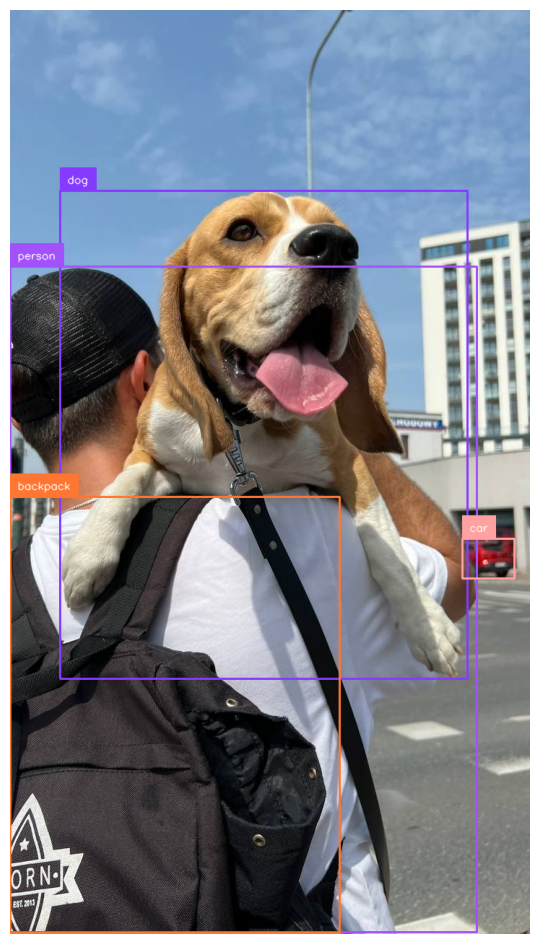

In [7]:
import os

# ✅ Disable FlashAttention (if on older GPUs)
os.environ["FLASHATTN_DISABLED"] = "1"

# ✅ Force CPU mode if GPU is incompatible
import torch
device = "cuda" if torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8 else "cpu"

# ✅ Import necessary libraries
from ultralytics import YOLO
import supervision as sv
import cv2

# ✅ Load image
image_path = "dog.jpeg"  # Replace with your image path
image = cv2.imread(image_path)

# ✅ Load YOLO model and move to appropriate device
model = YOLO("yolov12x.pt").to(device)

# ✅ Perform inference
results = model(image)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

# ✅ Annotate results
bounding_box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = bounding_box_annotator.annotate(scene=image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

# ✅ Display annotated image
sv.plot_image(annotated_image)

## Run inference

Let's run the `yolov12n` base model that was trained using the Microsoft COCO dataset. This model comes out of the box with YOLOv12.

We will then use the Roboflow `supervision` Python package to visualize the results from our model.


0: 640x384 1 person, 1 car, 1 dog, 1 backpack, 16.5ms
Speed: 1.9ms preprocess, 16.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


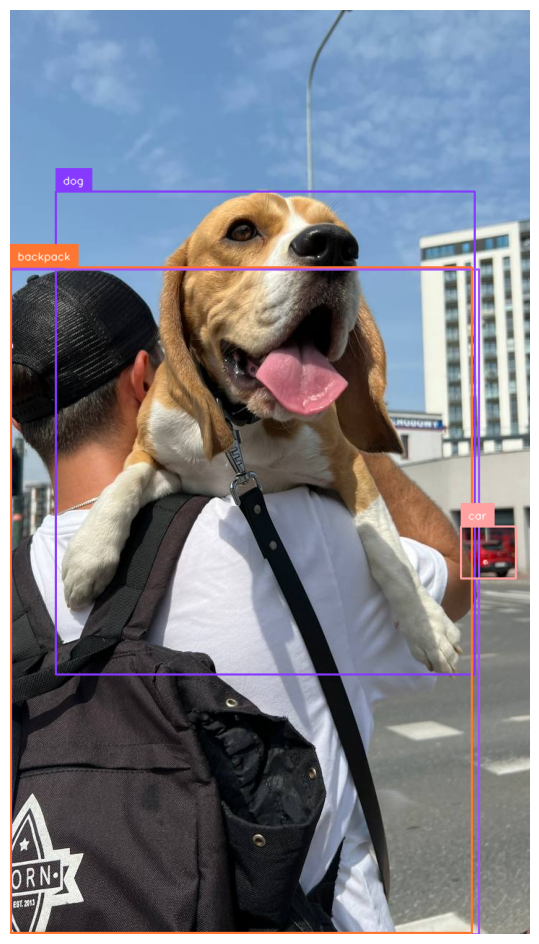

In [9]:
import os
os.environ["TORCH_USE_CUDA_FP16"] = "0"
from ultralytics import YOLO
import supervision as sv
import cv2

image = cv2.imread("dog.jpeg")

model = YOLO('yolov12n.pt')
results = model(image)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

bounding_box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = bounding_box_annotator.annotate(
    scene=image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

The YOLOv12 model successfully identifies the person and dog in the image.

You can experiment with different model sizes by replacing `yolov12n.pt` with:

- yolov12n.pt
- yolov12s.pt
- yolov12m.pt
- yolov12l.pt
- yolov12x.pt

## Train a model

Now, let's fine-tune a YOLOv12 model using a custom dataset.

For this guide, we will use a yard management dataset hosted on Roboflow Universe. This dataset contains images of shipping containers and other industrial objects.

We will:

- Download the dataset
- Train the model
- View the trained model confusion matrix
- Run our model on an image

### Download dataset from Roboflow Universe

If you do not already have one, create a [free Roboflow account](https://app.roboflow.com). When you run the code below, you will be asked for your API key. This will allow you to export the dataset we will use for training.

You can use any dataset in the [YOLOv8 PyTorch TXT format](https://roboflow.com/formats/yolov8-pytorch-txt).

In [10]:
!pip install roboflow --upgrade -q # Install the roboflow library

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 82.6 MB/s eta 0:00:00


In [11]:
from google.colab import userdata
from roboflow import Roboflow

#ROBOFLOW_API_KEY = userdata.get('MMQccvY9HKjgRLQzIwLO')

rf = Roboflow(api_key="MMQccvY9HKjgRLQzIwLO")
project = rf.workspace("bg-kim-sookmyung-ac-kr").project("pokercard_2023")
version = project.version(1)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to PokerCard_2023-1 in yolov8:: 100%|██████████| 525/525 [00:00<00:00, 1561.89it/s]


In [12]:
!ls
!pwd

app.py	  dog.jpeg.1  mkdocs.yml	requirements.txt      yolov12n.pt
assets	  examples    PokerCard_2023-1	tests		      yolov12x.pt
docker	  LICENSE     pyproject.toml	ultralytics
dog.jpeg  logs	      README.md		ultralytics.egg-info
/content/yolov12


We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following code to prepare your dataset for training:

In [13]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [14]:
# Inspect the data.yaml file to get the correct class names
!ls /content/yolov12/PokerCard_2023-1/valid/labels/
!cat /content/yolov12/PokerCard_2023-1/valid/data.yaml

cam_image10_jpg.rf.75efa2567f99b259646c28b364e8c112.txt
cam_image14_jpg.rf.87d5d51c9ac9fafb268764d98fa6a6ea.txt
cam_image22_jpg.rf.0b5f1b4fa9c0bae9fd3fa8bda8716590.txt
cam_image24_jpg.rf.38b564c05638f39f9e619ea0344bfea5.txt
cam_image26_jpg.rf.70dcbbb69b00d3f2eaadd6397bda6c72.txt
cam_image29_jpg.rf.f7cc453a2dabaa6ba62878a8488e686c.txt
cam_image30_jpg.rf.0cce4f085e9c4459ec4e9077d3b8c0ba.txt
cam_image34_jpg.rf.6e910e594acb4bf3f66a81e2e6c8761a.txt
cam_image43_jpg.rf.248607f0c465dd14656b001742d78f8a.txt
cam_image44_jpg.rf.8f5d92cedab7fdbd64f5dcaa4382b329.txt
cam_image47_jpg.rf.0c6c46e5eaac7c8775253638a55711e5.txt
cam_image52_jpg.rf.49ba8fa823b200b9f1b612cd598ce9ab.txt
cam_image54_jpg.rf.4e791646fd23e12f9d478e1154170c73.txt
IMG_2392_JPG.rf.5c58759f6fec5aae696eff67f98c7a54.txt
IMG_2399_JPG.rf.408d3dc0138ea5019c1c0f9f9e869e0b.txt
IMG_2431_JPG.rf.0be6d1a4de891184ddc6647232d3fbce.txt
IMG_2441_JPG.rf.48b56de1f97232d2ead9888a645d1e56.txt
IMG_2443_JPG.rf.1087e998024e0d0610d7771be1a5792a.txt
IMG_244

### Train the model

We are now ready to train a YOLOv12 model.

Below, repalce `yolov12s.yaml` with the checkpoint from which you want to start training. You can use:

- yolov12n.pt
- yolov12s.pt
- yolov12m.pt
- yolov12l.pt
- yolov12x.pt

We recommend training for at least 250 epochs.

Once you have set your training checkpoint, run the code cell below to start training.

**Note ⚠️:** After all epochs run, the `model()` will return a `TypeError: argument of type 'PosixPath' is not iterable` error. This has been [filed as an issue](https://github.com/sunsmarterjie/yolov12/issues/2). If you see this error after training, your model weights will still be saved and you can safely proceed to running inference.

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov12m.yaml')

results = model.train(
  data=f'{dataset.location}/data.yaml',
  epochs=250
)

New https://pypi.org/project/ultralytics/8.3.191 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12m.yaml, data=/content/yolov12/PokerCard_2023-1/data.yaml, epochs=250, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, sh

100%|██████████| 755k/755k [00:00<00:00, 22.0MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     37120  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2, 1, 2]         
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    147968  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2, 1, 4]        
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  2   2664960  ultralytics.nn.modules.block.A2C2f           [512, 512, 2, True, 4]        
  7                  -1  1   2360320  ultralytics

train: Scanning /content/yolov12/PokerCard_2023-1/train/labels... 225 images, 0 backgrounds, 0 corrupt: 100%|██████████| 225/225 [00:00<00:00, 2460.04it/s]

train: New cache created: /content/yolov12/PokerCard_2023-1/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/yolov12/PokerCard_2023-1/valid/labels... 21 images, 0 backgrounds, 0 corrupt: 100%|██████████| 21/21 [00:00<00:00, 1581.62it/s]

val: New cache created: /content/yolov12/PokerCard_2023-1/valid/labels.cache


Plotting labels to /content/yolov12/runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 131 weight(decay=0.0), 138 weight(decay=0.0005), 137 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/yolov12/runs/detect/train
Starting training for 250 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/250      13.2G      3.218       4.75      4.494          4        640: 100%|██████████| 15/15 [00:33<00:00,  2.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.25s/it]

                   all         21         33          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/250      12.7G      3.125      4.746      4.324          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

                   all         21         33          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/250      12.8G       3.19      4.472      4.171          4        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

                   all         21         33          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/250        13G      3.086      4.414      4.048          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         21         33          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/250      13.1G      3.091      4.181      3.902          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all         21         33          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/250      13.1G      2.967      4.013      3.795          6        640: 100%|██████████| 15/15 [00:13<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

                   all         21         33   0.000362      0.153   0.000906    0.00021



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/250      12.7G      2.914      3.929      3.654          4        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         21         33     0.0014      0.271     0.0113    0.00158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/250      12.8G      2.759      3.777       3.51          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all         21         33     0.0273      0.413      0.104     0.0242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/250      13.1G      2.679      3.573      3.401          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all         21         33      0.811     0.0833      0.138     0.0149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/250      12.8G      2.685      3.535      3.327          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all         21         33      0.836     0.0278    0.00337   0.000536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/250      12.7G      2.618      3.252      3.212          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         21         33      0.835     0.0556    0.00177   0.000347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/250      12.8G      2.499      3.143      3.136          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all         21         33      0.738      0.111     0.0917     0.0272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/250        13G      2.445      2.986      3.112          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all         21         33      0.542      0.132     0.0186    0.00676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/250      12.8G      2.446      2.932      3.093          4        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all         21         33      0.079      0.335     0.0612     0.0189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/250      12.7G      2.296      2.925      2.965          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         21         33      0.123      0.149      0.104     0.0523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/250      12.8G      2.157      2.657      2.867          7        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         21         33      0.576      0.382      0.453       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/250      13.1G      2.136       2.68      2.799          3        640: 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         21         33      0.868       0.36       0.54      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/250      12.8G      1.855      2.626      2.547          0        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

                   all         21         33      0.368      0.742      0.525      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/250      12.7G      1.975      2.462      2.681          6        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all         21         33      0.738      0.312      0.471      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/250      12.8G       1.93      2.422      2.698          3        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         21         33      0.298      0.428      0.458       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/250      13.4G      1.945       2.44      2.622          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all         21         33      0.191      0.543      0.339      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/250      12.8G      1.866      2.259      2.541          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         21         33        0.3      0.426      0.477      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/250      12.7G      1.927      2.404      2.585          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

                   all         21         33      0.234      0.463      0.328      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/250      12.8G      1.875      2.362      2.543          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         21         33      0.414      0.647      0.511      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/250      13.1G      1.718      2.108      2.431          5        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         21         33      0.458      0.602      0.541      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/250      12.8G      1.811      2.135      2.501          3        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         21         33      0.522      0.562      0.566      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/250      12.7G      1.694      2.036       2.38          5        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         21         33       0.41      0.747      0.587      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/250      12.8G      1.631      2.122      2.329          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all         21         33      0.318      0.504        0.5      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/250      12.7G      1.664       1.98      2.358          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         21         33      0.409      0.713       0.54      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/250      12.8G      1.564      1.968       2.26          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         21         33      0.343      0.652      0.519      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/250      12.8G      1.575      1.877      2.257          3        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all         21         33      0.401      0.731      0.552      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/250      12.8G      1.576      1.827      2.253          3        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all         21         33      0.489      0.695      0.573      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/250      13.1G      1.546      1.887      2.185          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         21         33      0.411      0.691       0.52      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/250      12.6G       1.54      1.824      2.218         47        640:  13%|█▎        | 2/15 [00:01<00:12,  1.06it/s]

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/yolov12/runs/detect/train/

args.yaml					   results.png
confusion_matrix_normalized.png			   train_batch0.jpg
confusion_matrix.png				   train_batch1.jpg
events.out.tfevents.1749700622.6e33772b51f6.199.0  train_batch2.jpg
F1_curve.png					   train_batch3600.jpg
labels_correlogram.jpg				   train_batch3601.jpg
labels.jpg					   train_batch3602.jpg
P_curve.png					   val_batch0_labels.jpg
PR_curve.png					   val_batch0_pred.jpg
R_curve.png					   weights
results.csv


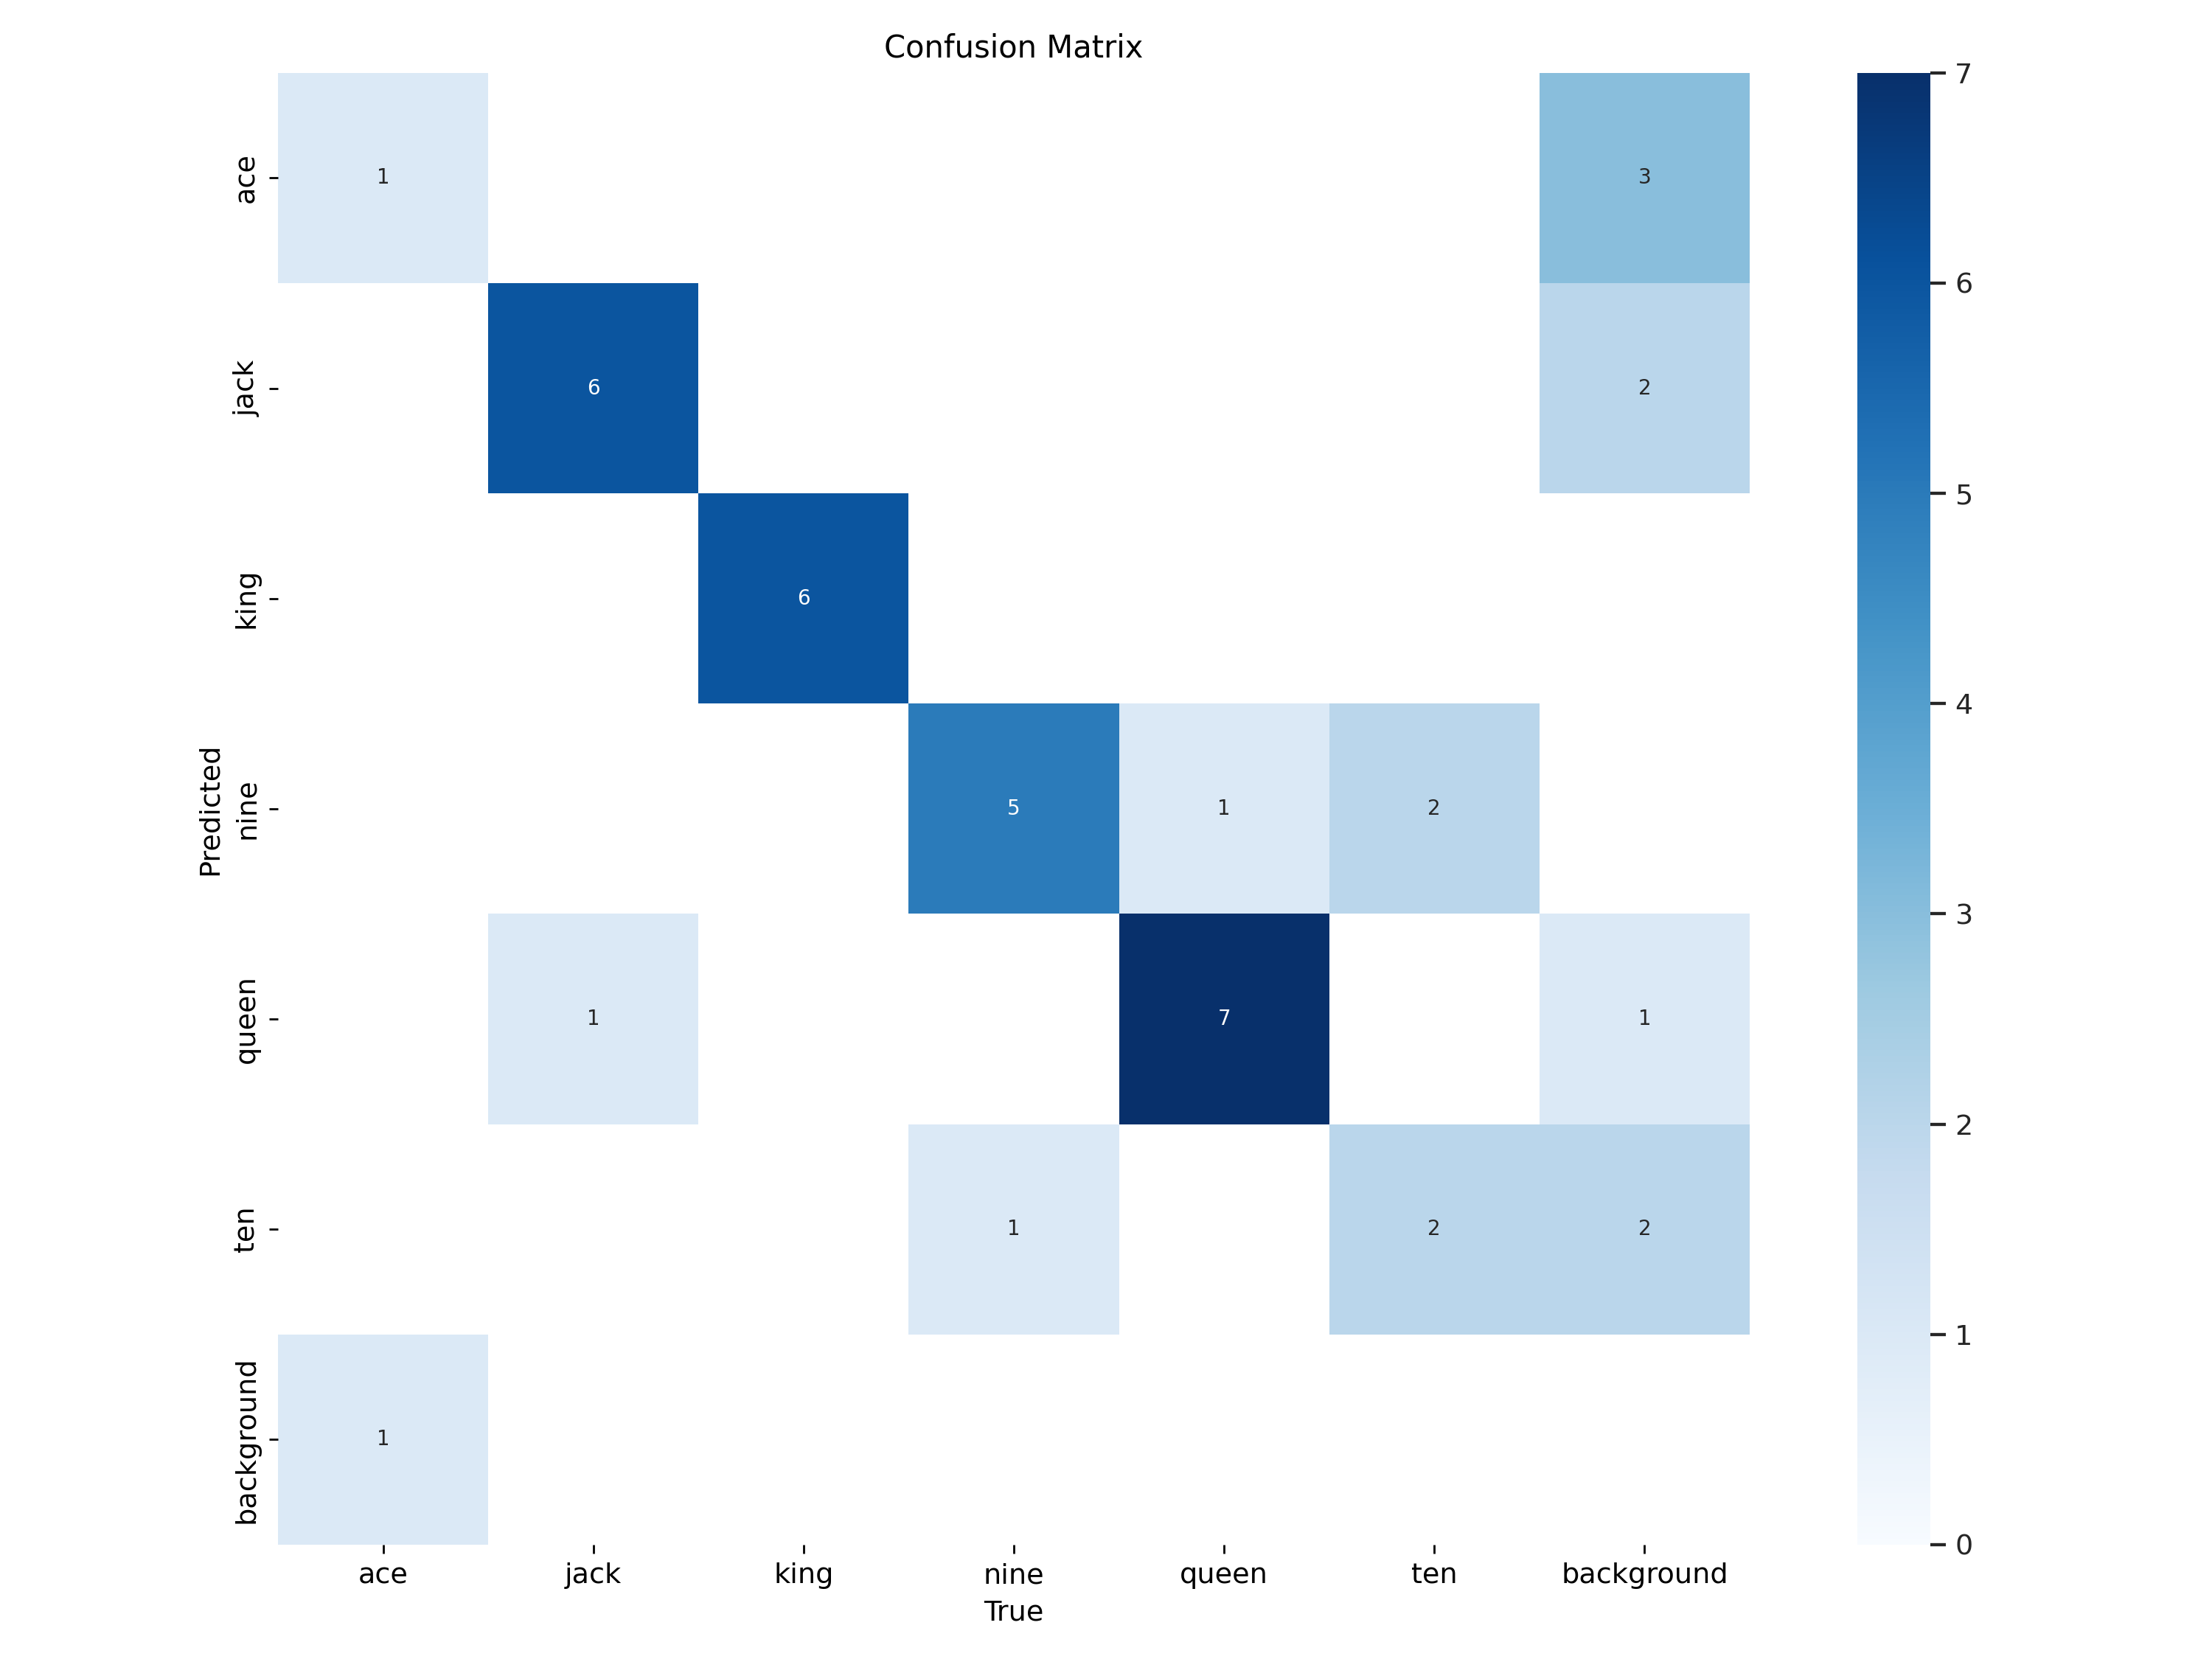

In [ ]:
from IPython.display import Image

Image(filename=f'/content/yolov12/runs/detect/train/confusion_matrix.png', width=600)

/content


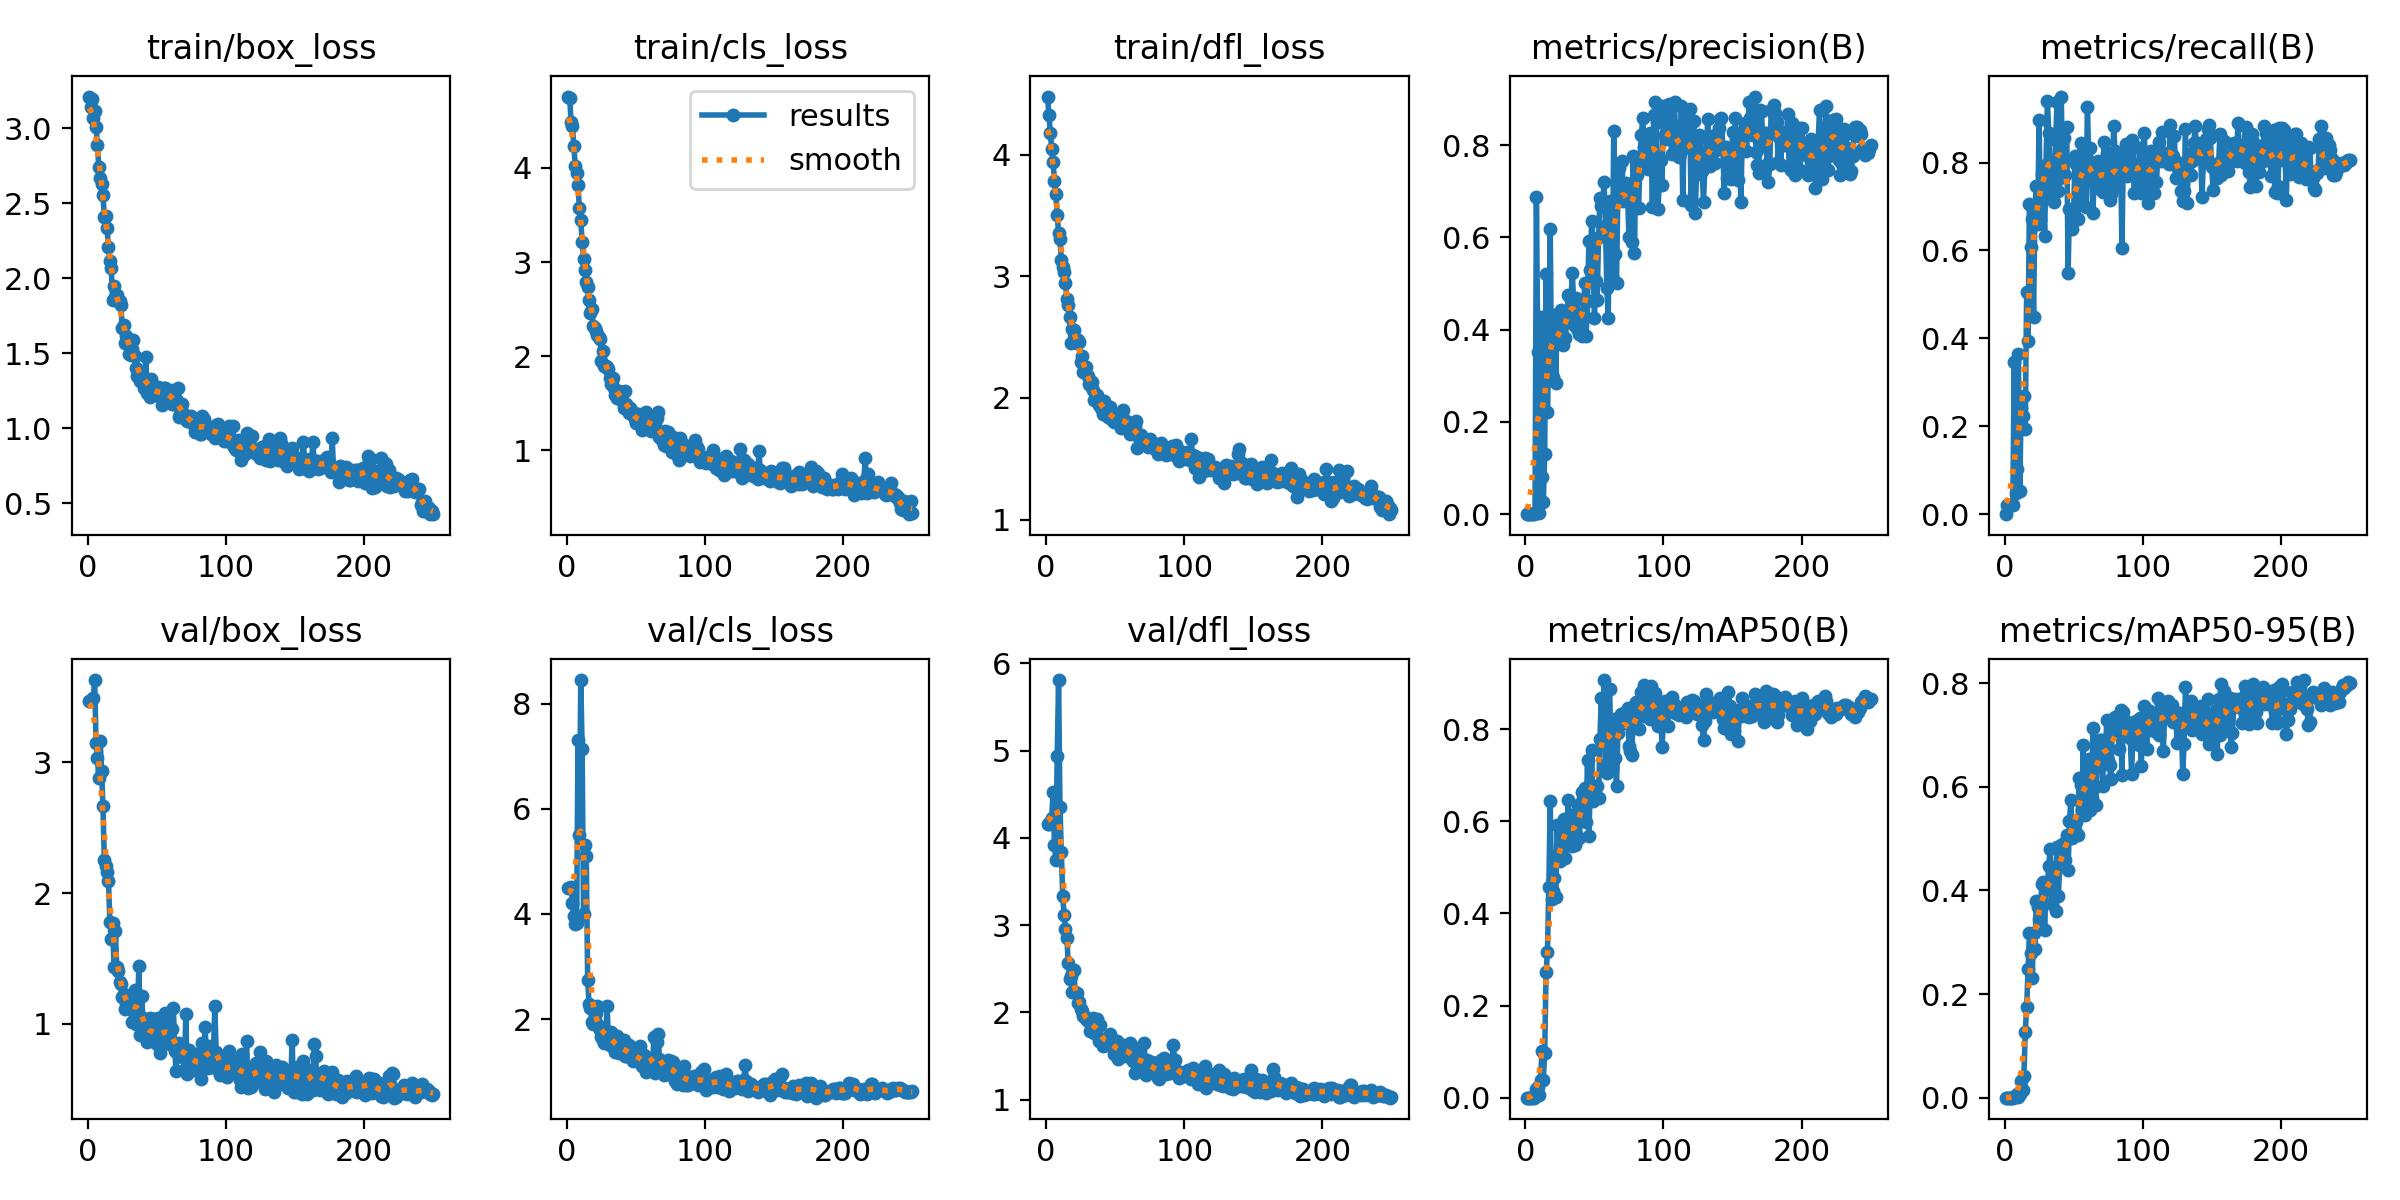

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/yolov12/runs/detect/train/results.png', width=600)

## Run inference with trained model

We can run our trained model on a random image from the `valid` set of our dataset using the following code:

In [ ]:
import random

model = YOLO(f"/{HOME}/yolov12/runs/detect/train/weights/best.pt")

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/valid/images",
    annotations_directory_path=f"{dataset.location}/valid/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

images is deprecated: `DetectionDataset.images` property is deprecated and will be removed in `supervision-0.26.0`. Iterate with `for path, image, annotation in dataset:` instead.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.



0: 640x640 1 jack, 44.6ms
Speed: 2.2ms preprocess, 44.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


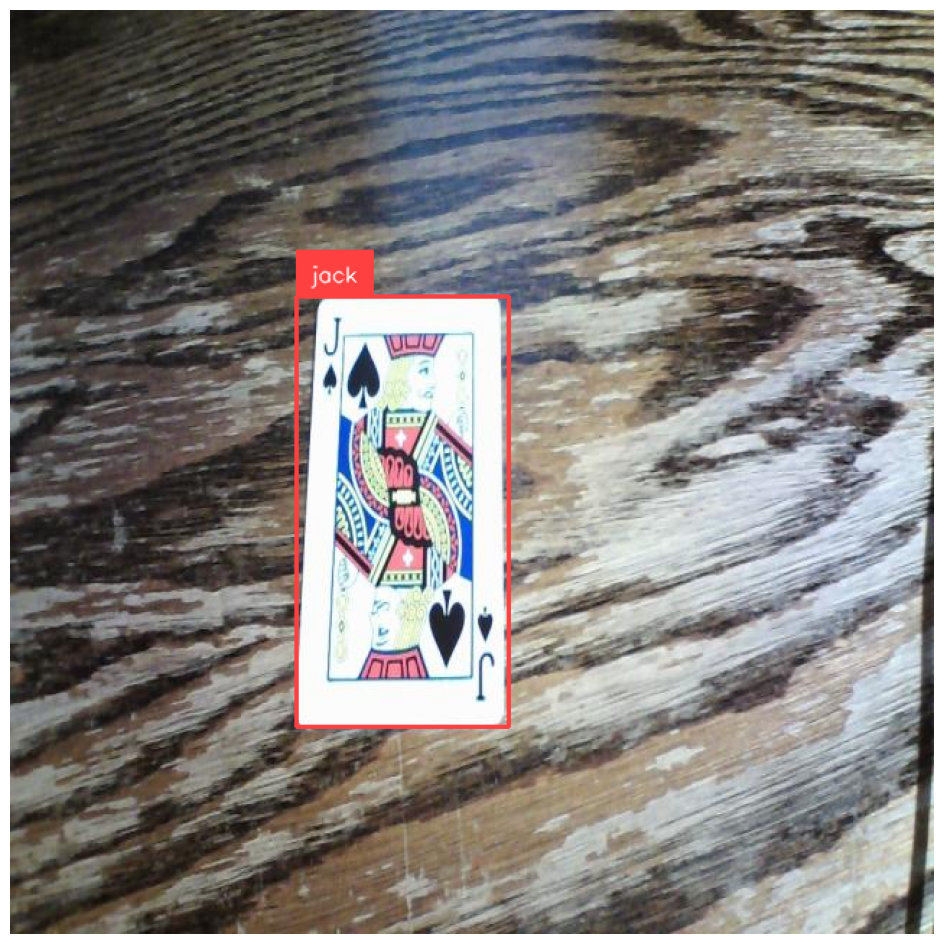

In [ ]:
image = random.choice(list(ds.images.keys()))
image = cv2.imread(image)

bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

results = model(image)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = bounding_box_annotator.annotate(
    scene=image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

In [ ]:
%cd /content/yolov12/
!ls -al /content/yolov12/ultralytics/engine/

/content/yolov12
total 304
drwxr-xr-x  3 root root  4096 Jun 12 03:55 .
drwxr-xr-x 13 root root  4096 Jun 12 03:55 ..
-rw-r--r--  1 root root 69155 Jun 12 03:51 exporter.py
-rw-r--r--  1 root root    70 Jun 12 03:51 __init__.py
-rw-r--r--  1 root root 53290 Jun 12 03:51 model.py
-rw-r--r--  1 root root 17740 Jun 12 03:51 predictor.py
drwxr-xr-x  2 root root  4096 Jun 12 03:55 __pycache__
-rw-r--r--  1 root root 75114 Jun 12 03:51 results.py
-rw-r--r--  1 root root 37434 Jun 12 03:51 trainer.py
-rw-r--r--  1 root root 11976 Jun 12 03:51 tuner.py
-rw-r--r--  1 root root 14901 Jun 12 03:51 validator.py


In [ ]:
%cd /content/yolov12/
!ls

/content/yolov12
app.py	  examples    PokerCard_2023-1	runs		      yolov12n.pt
assets	  LICENSE     pyproject.toml	tests		      yolov12x.pt
docker	  logs	      README.md		ultralytics
dog.jpeg  mkdocs.yml  requirements.txt	ultralytics.egg-info


In [ ]:
# export ONNX for ONNX inference
model.export(format="onnx", device = 'cpu', half=True, simplify=True)  # or format="onnx" or format="onnx"

Ultralytics 8.3.63 🚀 Python-3.11.13 torch-2.7.1+cu126 CPU (Intel Xeon 2.00GHz)
WARNING ⚠️ half=True only compatible with GPU export, i.e. use device=0

PyTorch: starting from '//content/yolov12/runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 10, 8400) (37.9 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 171.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.3/154.3 kB 205.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.2/283.2 MB 206.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 268.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 269.2 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 16.5s, installed 3 packages: ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command 

'//content/yolov12/runs/detect/train/weights/best.onnx'

In [ ]:
!ls /content/yolov12/runs/detect/train/weights/ -al

total 154492
drwxr-xr-x 2 root root     4096 Jun 12 05:06 .
drwxr-xr-x 3 root root     4096 Jun 12 05:04 ..
-rw-r--r-- 1 root root 78668235 Jun 12 05:06 best.onnx
-rw-r--r-- 1 root root 39758654 Jun 12 05:04 best.pt
-rw-r--r-- 1 root root 39758654 Jun 12 05:04 last.pt


In [ ]:
#Copy the weight/structure file to your Google drive (my drive)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/yolov12/runs/detect/train/weights/best.onnx /content/drive/MyDrive/yolov12_best3.onnx
!cp /content/yolov12/runs/detect/train/weights/best.pt /content/drive/MyDrive/yolov12_best.pt
!ls /content/drive/MyDrive *.onnx

# You can implement your local service with "yolov12_best.onnx" file where you have...!!!

ls: cannot access '*.onnx': No such file or directory
/content/drive/MyDrive:
'1. 2023년도 연구센터 평가결과보고서_양식_인공지능혁신연구센터.xlsx'
 1-s2.0-S0141938215000980-main.pdf
 20.09.10_사업자등록증_숙명여대산단.pdf
'2017-publication-9500-3차년도_중간점검(초안)(검토본).pptx'
 2019-CONTEXT-9500-1차년도-연차보고서_김병규교수님연구실_수정본.hwp
'2021년 지역특화산업육성+(R&D)지역주력산업육성 최종평가 보고서-210615-수정본.hwp'
'2024-2 (일반형)캡스톤디자인 결과보고서 양식_김병규.hwp'
'240416_2024년_약자를_위한기술개발_지원사업_과제계획서_숙대내용 보완본.hwp'
 2_별첨_기획처_전체교수회의_발표자료.pdf
'4_별첨3_연구처_세종대 전문가 특강 발표 요약.pdf'
 7BE9317B-6093-42D9-98D2-6F440380AB20.jpeg
'8-2021-138 - 수정_저자교정본(1).hwp'
'8-2021-138 - 수정_저자교정본.hwp'
 AI-and-Blockchain-powered-IoT_CFP.pdf
'A Study on Deep learning-based Hand Drawing Psychological Analysis_final.hwp'
 bus.jpg


In [ ]:
##---- Define processing functions -------#
import torchvision
import onnxruntime as ort
import time, random
import torch # Added torch import
import numpy as np # Added numpy import
import cv2 # Added cv2 import

img_size = 640

def box_iou(box1, box2, eps=1e-7):
        # https://github.com/pytorch/vision/blob/master/torchvision/ops/boxes.py
        """
        Return intersection-over-union (Jaccard index) of boxes.
        Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
        Arguments:
            box1 (Tensor[N, 4])
            box2 (Tensor[M, 4])
        Returns:
            iou (Tensor[N, M]): the NxM matrix containing the pairwise
                IoU values for every element in boxes1 and boxes2
        """

        # inter(N,M) = (rb(N,M,2) - lt(N,M,2)).clamp(0).prod(2)
        (a1, a2), (b1, b2) = box1.unsqueeze(1).chunk(2, 2), box2.unsqueeze(0).chunk(2, 2)
        inter = (torch.min(a2, b2) - torch.max(a1, b1)).clamp(0).prod(2)

        # IoU = inter / (area1 + area2 - inter)
        return inter / ((a2 - a1).prod(2) + (b2 - b1).prod(2) - inter + eps)

def non_max_suppression(prediction,
            conf_thres,
            iou_thres,
            classes=None,
            agnostic=False,
            multi_label=False,
            labels=(),
            max_det=300,
            nm=0,  # number of masks
    ):
        """Non-Maximum Suppression (NMS) on inference results to reject overlapping detections

        Returns:
            list of detections, on (n,6) tensor per image [xyxy, conf, cls]
        """

        if isinstance(prediction, (list, tuple)):  # YOLOv5 model in validation model, output = (inference_out, loss_out)
            prediction = prediction[0]  # select only inference output

        device = prediction.device
        mps = 'mps' in device.type  # Apple MPS
        if mps:  # MPS not fully supported yet, convert tensors to CPU before NMS
            prediction = prediction.cpu()
        bs = prediction.shape[0]  # batch size
        nc = prediction.shape[2] - nm - 5  # number of classes
        xc = prediction[..., 4] > conf_thres  # candidates

        # Checks
        assert 0 <= conf_thres <= 1, f'Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0'
        assert 0 <= iou_thres <= 1, f'Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0'

        # Settings
        # min_wh = 2  # (pixels) minimum box width and height
        max_wh = 7680  # (pixels) maximum box width and height
        max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
        time_limit = 0.5 + 0.05 * bs  # seconds to quit after
        redundant = True  # require redundant detections
        multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
        merge = False  # use merge-NMS

        t = time.time()
        mi = 5 + nc  # mask start index
        output = [torch.zeros((0, 6 + nm), device=prediction.device)] * bs
        for xi, x in enumerate(prediction):  # image index, image inference
            # Apply constraints
            # x[((x[..., 2:4] < min_wh) | (x[..., 2:4] > max_wh)).any(1), 4] = 0  # width-height
            x = x[xc[xi]]  # confidence

            # Cat apriori labels if autolabelling
            if labels and len(labels[xi]):
                lb = labels[xi]
                v = torch.zeros((len(lb), nc + nm + 5), device=x.device)
                v[:, :4] = lb[:, 1:5]  # box
                v[:, 4] = 1.0  # conf
                v[range(len(lb)), lb[:, 0].long() + 5] = 1.0  # cls
                x = torch.cat((x, v), 0)

            # If none remain process next image
            if not x.shape[0]:
                continue

            # Compute conf
            x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf

            # Box/Mask
            box = xywh2xyxy(x[:, :4])  # center_x, center_y, width, height) to (x1, y1, x2, y2)
            mask = x[:, mi:]  # zero columns if no masks

            # Detections matrix nx6 (xyxy, conf, cls)
            if multi_label:
                i, j = (x[:, 5:mi] > conf_thres).nonzero(as_tuple=False).T
                x = torch.cat((box[i], x[i, 5 + j, None], j[:, None].float(), mask[i]), 1)
            else:  # best class only
                conf, j = x[:, 5:mi].max(1, keepdim=True)
                x = torch.cat((box, conf, j.float(), mask), 1)[conf.view(-1) > conf_thres]

            # Filter by class
            if classes is not None:
                x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

            # Apply finite constraint
            # if not torch.isfinite(x).all():
            #     x = x[torch.isfinite(x).all(1)]

            # Check shape
            n = x.shape[0]  # number of boxes
            if not n:  # no boxes
                continue
            elif n > max_nms:  # excess boxes
                x = x[x[:, 4].argsort(descending=True)[:max_nms]]  # sort by confidence
            else:
                x = x[x[:, 4].argsort(descending=True)]  # sort by confidence

            # Batched NMS
            c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
            boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
            i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
            if i.shape[0] > max_det:  # limit detections
                i = i[:max_det]
            if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
                # update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
                iou = box_iou(boxes[i], boxes) > iou_thres  # iou matrix
                weights = iou * scores[None]  # box weights
                x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
                if redundant:
                    i = i[iou.sum(1) > 1]  # require redundancy

            output[xi] = x[i]
            if mps:
                output[xi] = output[xi].to(device)
            if (time.time() - t) > time_limit:
                # LOGGER.warning(f'WARNING ⚠️ NMS time limit {time_limit:.3f}s exceeded')
                break  # time limit exceeded

        return output


def xywh2xyxy(x):
        # Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
        y = torch.zeros_like(x) if isinstance(x, torch.Tensor) else np.zeros_like(x)
        y[:, 0] = x[:, 0] - x[:, 2] / 2  # top left x
        y[:, 1] = x[:, 1] - x[:, 3] / 2  # top left y
        y[:, 2] = x[:, 0] + x[:, 2] / 2  # bottom right x
        y[:, 3] = x[:, 1] + x[:, 3] / 2  # bottom right y
        return y

# Read classes.txt
def class_name():
        # UPDATE THIS LIST with the correct class names from your data.yaml file
        classes=['ace', 'king', 'queen', 'jack', 'ten', 'nine']
        return classes

def letterbox(im, color=(114, 114, 114), auto=True, scaleup=True, stride=32):
        # Resize and pad image while meeting stride-multiple constraints
        shape = im.shape[:2]  # current shape [height, width]
        new_shape= img_size
        if isinstance(new_shape, int):
            new_shape = (new_shape, new_shape)

        # Scale ratio (new / old)
        r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
        if not scaleup:  # only scale down, do not scale up (for better val mAP)
            r = min(r, 1.0)

        # Compute padding
        new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
        dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

        if auto:  # minimum rectangle
            dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

        dw /= 2  # divide padding into 2 sides
        dh /= 2

        if shape[::-1] != new_unpad:  # resize
            im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
        top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
        left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
        im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
        return im, r, (dw, dh)

# Initialize ONNXRuntime session
def ort_session(onnx_model):
        providers = ['CUDAExecutionProvider', 'CPUExecutionProvider'] if ort.get_device()=='GPU' else ['CPUExecutionProvider']
        session = ort.InferenceSession(onnx_model, providers=providers)
        print(session.get_providers())

        return session

# Display results
def result(img,ratio, dwdh, out):
        names= class_name()
        colors = {name:[random.randint(0, 255) for _ in range(3)] for i,name in enumerate(names)}
        for i,(x0,y0,x1,y1,score,cls_id) in enumerate(out):
            box = np.array([x0,y0,x1,y1])
            box -= np.array(dwdh*2)
            box /= ratio
            box = box.round().astype(np.int32).tolist()
            cls_id = int(cls_id)
            print("Class id :", cls_id)
            # Add a check to ensure cls_id is within the valid range
            if 0 <= cls_id < len(names):
                score = round(float(score),3)
                name = names[cls_id]
                color = colors[name]
                name += ' '+str(score)
                cv2.rectangle(img,box[:2],box[2:],color,2)
                cv2.putText(img,name,(box[0], box[1] - 2),cv2.FONT_HERSHEY_SIMPLEX,0.75,[225, 255, 255],thickness=2)
            else:
                print(f"Invalid class ID {cls_id}, skipping detection.")
                continue
        return img
        # cv2.imwrite('v5_onnx.jpg', img)
        # cv2.imshow('result',img)
        # cv2.waitKey(0)

In [ ]:
!cp /content/drive/MyDrive/cam_image52.jpg .
!ls -al
!pwd

total 122760
drwxr-xr-x 12 root root      4096 Jun 12 05:08 .
drwxr-xr-x  1 root root      4096 Jun 12 05:08 ..
-rw-r--r--  1 root root      5674 Jun 12 03:51 app.py
drwxr-xr-x  2 root root      4096 Jun 12 03:51 assets
-rw-------  1 root root    156014 Jun 12 05:08 cam_image52.jpg
drwxr-xr-x  2 root root      4096 Jun 12 03:51 docker
-rw-r--r--  1 root root    106055 Jun  2  2023 dog.jpeg
drwxr-xr-x 16 root root      4096 Jun 12 03:51 examples
drwxr-xr-x  8 root root      4096 Jun 12 03:51 .git
-rw-r--r--  1 root root     34523 Jun 12 03:51 LICENSE
drwxr-xr-x  2 root root      4096 Jun 12 03:51 logs
-rw-r--r--  1 root root     36633 Jun 12 03:51 mkdocs.yml
drwxr-xr-x  5 root root      4096 Jun 12 03:56 PokerCard_2023-1
-rw-r--r--  1 root root      7892 Jun 12 03:51 pyproject.toml
-rw-r--r--  1 root root     12201 Jun 12 03:51 README.md
-rw-r--r--  1 root root       409 Jun 12 03:51 requirements.txt
drwxr-xr-x  3 root root      4096 Jun 12 03:56 runs
drwxr-xr-x  2 root root      4096 J

In [ ]:
!ls /content/yolov12/runs/detect/train/weights/ -al

total 154492
drwxr-xr-x 2 root root     4096 Jun 12 05:06 .
drwxr-xr-x 3 root root     4096 Jun 12 05:04 ..
-rw-r--r-- 1 root root 78668235 Jun 12 05:06 best.onnx
-rw-r--r-- 1 root root 39758654 Jun 12 05:04 best.pt
-rw-r--r-- 1 root root 39758654 Jun 12 05:04 last.pt


['CUDAExecutionProvider', 'CPUExecutionProvider']
Predictions: tensor([[ 5.6269e+01,  3.8306e+01,  1.5983e+02,  1.4990e+02,  5.6427e+04,  8.1680e+03],
        [ 6.9996e+01,  6.8212e+01,  1.5196e+02,  1.3973e+02,  3.4682e+04,  8.2250e+03],
        [-8.0142e+00, -2.3693e+00,  1.3511e+01,  2.7485e+01,  2.4743e+04,  6.3140e+03],
        [ 1.5964e+00,  2.2734e+00,  8.7160e+00,  9.7865e+00,  4.7575e+03,  6.3910e+03]])
yolov12 ONNXRuntime Inference Time: 0.4665994644165039
Number of class names: tensor([[ 5.6269e+01,  3.8306e+01,  1.5983e+02,  1.4990e+02,  5.6427e+04,  8.1680e+03],
        [ 6.9996e+01,  6.8212e+01,  1.5196e+02,  1.3973e+02,  3.4682e+04,  8.2250e+03],
        [-8.0142e+00, -2.3693e+00,  1.3511e+01,  2.7485e+01,  2.4743e+04,  6.3140e+03],
        [ 1.5964e+00,  2.2734e+00,  8.7160e+00,  9.7865e+00,  4.7575e+03,  6.3910e+03]]) 1
Class id : 8168
Invalid class ID 8168, skipping detection.
Class id : 8225
Invalid class ID 8225, skipping detection.
Class id : 6314
Invalid class ID 

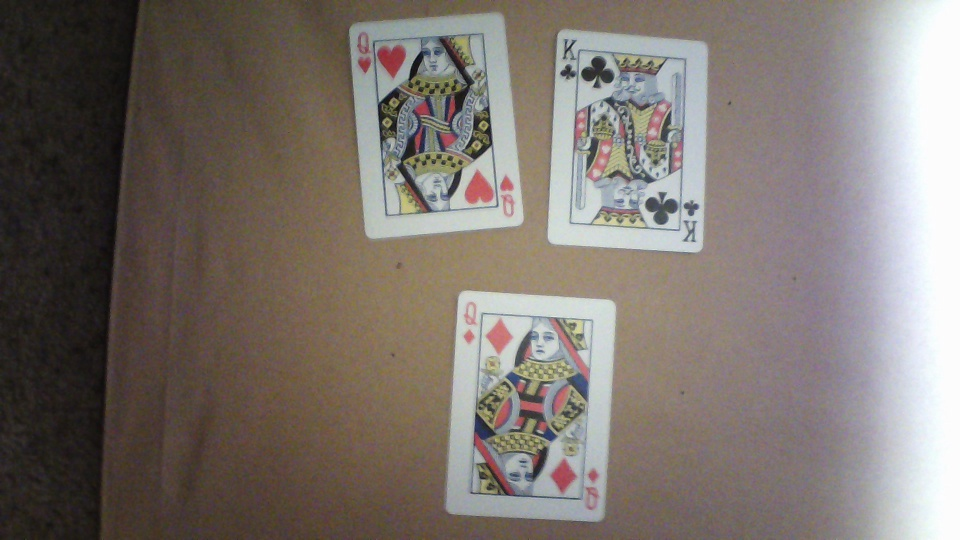

In [ ]:
# Inference for ONNX model
import torch
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

cuda = True
w = "/content/yolov12/runs/detect/train/weights/best.onnx"
img = cv2.imread('/content/yolov12/cam_image52.jpg')
image, ratio, dwdh = letterbox(img, auto=False)
image = image.transpose((2, 0, 1))
image = np.expand_dims(image, 0)
image = np.ascontiguousarray(image)
im = image.astype(np.float32)
im /= 255

#onnxruntime session
session= ort_session(w)
outname = [i.name for i in session.get_outputs()]
inname = [i.name for i in session.get_inputs()]

# print('input-output names:',inname,outname)
inp = {inname[0]:im}

# ONNXRuntime inference
t1 = time.time()
outputs = session.run(outname, inp)[0]
t2 = time.time()
output= torch.from_numpy(outputs)
out = non_max_suppression(output, conf_thres=0.25, iou_thres=0.45)[0]
print('Predictions:',out)
print('yolov12 ONNXRuntime Inference Time:', t2-t1)
print('Number of class names:', out, len(outname))
imgout=result(img, ratio, dwdh, out)
cv2.imwrite('result.jpg', imgout)
# print('result', img.shape)
# cv2.imshow('result',img)
# cv2.waitKey(0)
cv2_imshow(imgout)

Our model successfully identified objects in our image.

## 🏆 Congratulations

